----
# **0. Install Library**
----

In [1]:
# 한글 표기를 위해 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

# 라이브러리 설치
!pip install tqdm
!pip install konlpy

# konlpy, Mecab 설치
# Reference: https://teddylee777.github.io/colab/colab-mecab
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,468 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

----
# **1. Data Cleaning**
----
 - 결측치 확인 => 제거
 - 중복 리뷰 확인 => 제거

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
from tqdm.notebook import tqdm

In [4]:
# 데이터 로드
genre = '드라마'
PATH = '/content/drive/MyDrive/final-project/data'
df = pd.read_csv(PATH + f'/movie_crawling_{genre}.csv', index_col=0)
df.head()

,genre,movie_name,score,review
0,드라마,그린 북,10,폭설내리는밤 경찰이 두번째로 주인공이 몰고가는 차를 세웠을때 우린 경찰의 대사나 행...
1,드라마,그린 북,10,우리가 말모이와 스윙키즈처럼 중요한 역사적 소재에 빚지고도 허구의 신파 한가득 버무...
2,드라마,그린 북,10,"하.. 이런 영화가 상영관수, 상영시간을 많이 늘려야 되는데.. 진짜 예고편만 화려..."
3,드라마,그린 북,10,보고나면 KFC 치킨이 존나 떙기는 영화임..
4,드라마,그린 북,10,빗속 셜리의 대사는 소름이 끼쳤다


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816159 entries, 0 to 816158
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   genre       816159 non-null  object
 1   movie_name  816159 non-null  object
 2   score       816159 non-null  int64 
 3   review      805090 non-null  object
dtypes: int64(1), object(3)
memory usage: 31.1+ MB


In [6]:
# 결측치 확인
# => 1202개(판타지)
# => 11069(드라마)
df.isna().sum()

genre             0
movie_name        0
score             0
review        11069
dtype: int64

In [12]:
# 결측치 리뷰 확인
df[df['review'].isna()].head(10)

,genre,movie_name,score,review
443,드라마,그린 북,10,NaN
1399,드라마,가버나움,10,NaN
1962,드라마,원더,10,NaN
1986,드라마,원더,10,NaN
2008,드라마,원더,10,NaN
2011,드라마,원더,10,NaN
2013,드라마,원더,10,NaN
2042,드라마,원더,10,NaN
2119,드라마,원더,10,NaN
2120,드라마,원더,8,NaN


In [13]:
# 결측치 제거
df = df.dropna()

In [15]:
# 중복되는 리뷰 확인
# => 10519개(판타지)
# => 151014개(드라마)
duplication_check = df.duplicated(['review'])
duplication_check.sum()

151014

In [16]:
# 중복데이터 확인
dup = df[duplication_check == 1]
dup

,genre,movie_name,score,review
16,드라마,그린 북,10,관람객
17,드라마,그린 북,10,관람객
18,드라마,그린 북,10,관람객
24,드라마,그린 북,9,관람객
29,드라마,그린 북,8,관람객
...,...,...,...,...
816041,드라마,최미역행,1,FREE HONGKONG
816046,드라마,최미역행,1,스포일러가 포함된 감상평입니다. 감상평 보기
816064,드라마,최미역행,1,Taiwan NO.1
816075,드라마,최미역행,1,스포일러가 포함된 감상평입니다. 감상평 보기


In [27]:
# 유니크한 중복데이터 확인
print(len(dup['review'].unique()))
print(dup['review'].unique())

5826
['관람객' '스포일러가 포함된 감상평입니다. 감상평 보기' '많은 사람들이 꼭 봤으면 하는 영화' ... 'ㅗ'
 'FREE HONGKONG' 'Taiwan NO.1']


In [28]:
# 중복 제거
# 데이터 76553개(판타지), 654076(드라마)
df = df.drop_duplicates(['review'])
len(df)

654076

----
# **2. Data Preprocessing**
----
 - 리뷰에서 키워드가 될 수 있는 명사만 추출
 - 형태소 분석기(Okt, Mecab) 비교
 - **Mecab** 사용
    - 매우 빠른 실행속도 (65만개 51분 43초 VS 1분 23초)
    - 더 세부적인 품사태깅 (일반명사, 고유명사, 의존명사, 수사 등)
 - Mecab으로 **일반명사(NNG)**, **고유명사(NNP)**만 추출
 - 명사추출 후 **불용어 제거**, **1글자 단어** 제거
 

## 분석 성능 비교

### **1) 분석 품질**

In [29]:
# 형태소 분석기 이용해 명사만 뽑아내는 과정
# 형태소 분석기는 Mecab 사용 (okt, kkma, Komoran 등등 존재)
from konlpy.tag import Okt, Mecab

okt = Okt()
mecab = Mecab()

In [61]:
# 134, 64
okt.pos(df['review'][64])

[('최근', 'Noun'),
 ('에', 'Josa'),
 ('본', 'Verb'),
 ('영화', 'Noun'),
 ('중', 'Noun'),
 ('최고다', 'Noun'),
 ('.', 'Punctuation'),
 ('난', 'Noun'),
 ('이런', 'Adjective'),
 ('영화', 'Noun'),
 ('가', 'Josa'),
 ('좋더라', 'Adjective'),
 ('.', 'Punctuation'),
 ('특히', 'Adverb'),
 ('둘', 'Noun'),
 ('의', 'Josa'),
 ('우정은', 'Noun'),
 ('빛났다', 'Verb'),
 ('.', 'Punctuation')]

In [62]:
# NNG:일반명사, NNP: 고유명사, NNB: 의존명사, NR: 수사, MAG: 일반부사
mecab.pos(df['review'][64])

[('최근', 'NNG'),
 ('에', 'JKB'),
 ('본', 'VV+ETM'),
 ('영화', 'NNG'),
 ('중', 'NNB'),
 ('최고', 'NNG'),
 ('다', 'VCP+EF'),
 ('.', 'SF'),
 ('난', 'NP+JX'),
 ('이런', 'MM'),
 ('영화', 'NNG'),
 ('가', 'JKS'),
 ('좋', 'VA'),
 ('더라', 'EF'),
 ('.', 'SF'),
 ('특히', 'MAG'),
 ('둘', 'NR'),
 ('의', 'JKG'),
 ('우정', 'NNG'),
 ('은', 'JX'),
 ('빛났', 'VV+EP'),
 ('다', 'EF'),
 ('.', 'SF')]

#### **Okt normalizing 테스트**

In [ ]:
# 문장 정규화 테스트
# okt.normalize 사용
review_list = df['review'].tolist()
n_review = []
for review in tqdm(review_list):
    result = okt.normalize(review)
    n_review.append(result)
n_review[:7]

In [ ]:
# 정규화 전, 후 차이 확인
# 이건 => 이것은
# 재밋엇어 => 재밌엇어
# 반복되는 문자 처리
# 큰차이 X

cnt = 0
for n, (i, j) in enumerate(zip(review_list, n_review)):
#     if n == 50:
#         break
    if i != j:
        cnt += 1
        print(i)
        print(j)
print(cnt)

이건 영화라는 장르를 넘어섰다. 100년후에도 영화라는 문화를 다룰때, 언급될 작품이 되지않을까.?
이것은 영화라는 장르를 넘어섰다. 100년후에도 영화라는 문화를 다룰때, 언급될 작품이 되지않을까.?
역대 아카데미 11관왕한 작품이 1959년 벤허, 1997년 타이타닉, 2003년 반지의 제왕: 왕의 귀환 단 세 편뿐이 없다. 무슨 말이 필요하냐 그냥 보라는 뜻이다. 이건 판타지 영화의 교과서다.
역대 아카데미 11관왕한 작품이 1959년 벤허, 1997년 타이타닉, 2003년 반지의 제왕: 왕의 귀환 단 세 편뿐이 없다. 무슨 말이 필요하냐 그냥 보라는 뜻이다. 이것은 판타지 영화의 교과서다.
명불허전. 영화끝났을때 마지막이라는게 너무아쉬웠어요.다행히 호빗이 나와서 달래주고있지만.죽기전에 이런영화는또안나올거같네요.단순히 영화를 넘어서 진짜 그런 세계가잇엇던듯 한 느낌ㅎㅎ
명불허전. 영화끝났을때 마지막이라는게 너무아쉬웠어요.다행히 호빗이 나와서 달래주고있지만.죽기전에 이런영화는또안나올거같네요.단순히 영화를 넘어서 진짜 그런 세계가있었던듯 한 느낌ㅎㅎ
이건 영화가 아닙니다. 어쩌면 우주라는 세계관으로봤을떄 모든 인류의 역사를 대표할만한 예술작품
이것은 영화가 아닙니다. 어쩌면 우주라는 세계관으로봤을떄 모든 인류의 역사를 대표할만한 예술작품
뉴질랜드에 잠시 살고있을 때 세계 최초로 개막했는데 그때 개봉일 날 초청티켓 받고 자막없이 본 영화 ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ 생생하다 ...
뉴질랜드에 잠시 살고있을 때 세계 최초로 개막했는데 그때 개봉일 날 초청티켓 받고 자막없이 본 영화 ㅠㅠㅠ 생생하다 ...
거짓말 조금 보태서 백번은 본것 같다..처음 개봉당시 극장서 충격먹고 다음 시리즈 기다리는 설레임에 살았지..그런데 지금도 혼자 생각하는게 있다..그냥 첨부터 프로도가 반지를 가지고 독수리를 타고 가서 파괴할 수는 ...
거짓말 조금 보태서 백번은 본것 같다..처음 개봉당시 극장서 충격먹고 다음 시리즈 기다리는 설레임에 살았지..그런데 지금도 혼

### **2) 소요시간**

In [69]:
# 51분 43초
df['review'].apply(okt.nouns)

0         [폭설, 밤, 경찰, 두번째, 주인공, 차, 때, 우린, 경찰, 대사, 행동, 예측...
1         [우리, 말, 모이, 스윙, 키즈, 역사, 소재, 빚, 고도, 허구, 신파, 버, ...
2                [영화, 상영, 관수, 상영, 시간, 진짜, 예고편, 거품, 영화, 독차지]
3                                       [치킨, 존나, 떙기, 영화, 임]
4                                          [빗속, 셜리, 대사, 소름]
                                ...                        
816153                                          [걸, 개봉, 정신]
816154    [진짜, 제대로, 짱깨, 새끼, 개, 쓰레기, 영화, 생각, 정신, 배급사, 기획,...
816155                                               [뭐, 뻔]
816156                       [그냥, 중국, 국뽕, 영화, 말, 개, 소리, 진짜]
816157                                       [쓰레기, 쓰레기, 물건]
Name: review, Length: 654076, dtype: object

In [70]:
# 1분 23초
# Mecab으로 명사 추출

# 문장을 입력받아 품사태깅 후 NNG와 NNP만 추출하는 함수
def NNGNNP(sentence):
    nouns = []
    result = mecab.pos(sentence)
    for element in result:
        if element[1] == 'NNG' or element[1] == 'NNP':
            nouns.append(element[0])
    return nouns


# NNG, NNP 명사만 추출한 Review라는 새로운 col 생성
df['Review'] = ''
df['Review'] = df['review'].apply(NNGNNP)
df.head()

,genre,movie_name,score,review,Review
0,드라마,그린 북,10,폭설내리는밤 경찰이 두번째로 주인공이 몰고가는 차를 세웠을때 우린 경찰의 대사나 행...,"[폭설, 밤, 경찰, 주인공, 차, 때, 경찰, 대사, 행동, 예측, 예측, 자체,..."
1,드라마,그린 북,10,우리가 말모이와 스윙키즈처럼 중요한 역사적 소재에 빚지고도 허구의 신파 한가득 버무...,"[말모이, 스윙, 키즈, 중요, 역사, 소재, 허구, 신파, 눈물, 의미, 영화, ..."
2,드라마,그린 북,10,"하.. 이런 영화가 상영관수, 상영시간을 많이 늘려야 되는데.. 진짜 예고편만 화려...","[영화, 상영관, 수, 상영, 시간, 예고편, 거품, 영화, 독차지]"
3,드라마,그린 북,10,보고나면 KFC 치킨이 존나 떙기는 영화임..,"[치킨, 영화]"
4,드라마,그린 북,10,빗속 셜리의 대사는 소름이 끼쳤다,"[빗속, 셜리, 대사, 소름]"


## **불용어 제거**
 - **불용어 사전** 등록 단어 제거
    - 자주 등장하는, 상위 빈도수의 영화와 관련된 보편적인 단어
    - 부사, 형용사적 의미를 갖는 명사
    - 나라이름
 - **1글자 단어** 제거

In [72]:
# 불용어 사전
# 1. 자주 등장하는, 상위 빈도수의 영화와 관련된 보편적인 단어: 영화제목들, 영화, 관람객, 생각, 평점, 해리포터, 하나, 작품, 아이, 
# 2. 부사, 형용사적 의미를 갖는 명사: 정말, 진짜, 최고, 그냥 등등
# 3. 국가명

# 불용어 사전 정의
stopword = ['정말', '진짜', '최고', '그냥', '마지막', '다시', '완전', '정도', '역시', '처음', '지금', '이건', '별로', '때문', '뭔가', '가장', '조금', '제일',
            '영화', '관람객', '생각', '평점', '하나', '작품', '아이', '최악', '일본', '미국', '중국', '호주', '프랑스', '한국', '인도']

# 영화 타이틀 추가
for title in df['movie_name'].unique().tolist():
    stopword.append(title)

# 불용어 사전 확인
print(len(stopword))
print(stopword)

1148
['정말', '진짜', '최고', '그냥', '마지막', '다시', '완전', '정도', '역시', '처음', '지금', '이건', '별로', '때문', '뭔가', '가장', '조금', '제일', '영화', '관람객', '생각', '평점', '하나', '작품', '아이', '최악', '일본', '미국', '중국', '호주', '프랑스', '한국', '인도', '그린 북', '가버나움', '원더', '아일라', '먼 훗날 우리', '당갈', '쇼생크 탈출', '덕구', '보헤미안 랩소디', '포레스트 검프', '위대한 쇼맨', '인생은 아름다워', '헬프', '캐스트 어웨이', '히든 피겨스', '쉰들러 리스트', '집으로...', '죽은 시인의 사회', '아이 캔 스피크', '동주', '여인의 향기', '미스 슬로운', '굿바이 마이 프랜드', '굿 윌 헌팅', '지상의 별처럼', '아마데우스', '자산어보', '빌리 엘리어트', '두 교황', '그대를 사랑합니다', '아이 엠 샘', '피아니스트', '시네마 천국', '달링', '소원', '블라인드 사이드', '패왕별희 디 오리지널', '뷰티풀 투모로우', '우리들의 일그러진 영웅', '코러스', '8월의 크리스마스', '일급 살인', '허스토리', '내 이름은 칸', '록키', '나, 다니엘 블레이크', '시월애', '언플랜드', '인생', '우리들', '공동경비구역 JSA', '천국의 아이들', '맨발의 꿈', '랜드 오브 마인', '세상에서 가장 아름다운 이별', '바람', '도가니', '온리 더 브레이브', '또 하나의 약속', '피아니스트의 전설', '신데렐라 맨', '투게더', '기적', '뷰티풀 마인드', '광해, 왕이 된 남자', '쿨 러닝', '친정엄마', '미안해요, 리키', '집으로 가는 길', '바람과 함께 사라지다', '타인의 삶', '라이언', '말아톤', '킹콩을 들다', '맨 오브 오너', '파워 오브 원', '1987', '핵소 고지', '벤허', '로미오와 줄리엣', 

In [73]:
# 불용어 제거 함수
def RemoveStopWord(ls):
    clean_review = []
    for element in ls:
        if len(element) == 1 or element in stopword:
            continue
        clean_review.append(element)
    return clean_review

df['Review'] = df['Review'].apply(RemoveStopWord)
df.head()

,genre,movie_name,score,review,Review
0,드라마,그린 북,10,폭설내리는밤 경찰이 두번째로 주인공이 몰고가는 차를 세웠을때 우린 경찰의 대사나 행...,"[폭설, 경찰, 주인공, 경찰, 대사, 행동, 예측, 예측, 자체, 편견, 뒤통수,..."
1,드라마,그린 북,10,우리가 말모이와 스윙키즈처럼 중요한 역사적 소재에 빚지고도 허구의 신파 한가득 버무...,"[스윙, 키즈, 중요, 역사, 소재, 허구, 신파, 눈물, 의미, 자아, 동안, 헐..."
2,드라마,그린 북,10,"하.. 이런 영화가 상영관수, 상영시간을 많이 늘려야 되는데.. 진짜 예고편만 화려...","[상영관, 상영, 시간, 예고편, 거품, 독차지]"
3,드라마,그린 북,10,보고나면 KFC 치킨이 존나 떙기는 영화임..,[치킨]
4,드라마,그린 북,10,빗속 셜리의 대사는 소름이 끼쳤다,"[빗속, 셜리, 대사, 소름]"


In [74]:
# 전처리 후 빈 리뷰는 제거
df = df[df['Review'].apply(len) != 0]
df.head()

,genre,movie_name,score,review,Review
0,드라마,그린 북,10,폭설내리는밤 경찰이 두번째로 주인공이 몰고가는 차를 세웠을때 우린 경찰의 대사나 행...,"[폭설, 경찰, 주인공, 경찰, 대사, 행동, 예측, 예측, 자체, 편견, 뒤통수,..."
1,드라마,그린 북,10,우리가 말모이와 스윙키즈처럼 중요한 역사적 소재에 빚지고도 허구의 신파 한가득 버무...,"[스윙, 키즈, 중요, 역사, 소재, 허구, 신파, 눈물, 의미, 자아, 동안, 헐..."
2,드라마,그린 북,10,"하.. 이런 영화가 상영관수, 상영시간을 많이 늘려야 되는데.. 진짜 예고편만 화려...","[상영관, 상영, 시간, 예고편, 거품, 독차지]"
3,드라마,그린 북,10,보고나면 KFC 치킨이 존나 떙기는 영화임..,[치킨]
4,드라마,그린 북,10,빗속 셜리의 대사는 소름이 끼쳤다,"[빗속, 셜리, 대사, 소름]"


In [75]:
# 인덱스 초기화
df = df.reset_index()
df = df.drop(['index'], axis=1)

In [76]:
df.head(10)

,genre,movie_name,score,review,Review
0,드라마,그린 북,10,폭설내리는밤 경찰이 두번째로 주인공이 몰고가는 차를 세웠을때 우린 경찰의 대사나 행...,"[폭설, 경찰, 주인공, 경찰, 대사, 행동, 예측, 예측, 자체, 편견, 뒤통수,..."
1,드라마,그린 북,10,우리가 말모이와 스윙키즈처럼 중요한 역사적 소재에 빚지고도 허구의 신파 한가득 버무...,"[스윙, 키즈, 중요, 역사, 소재, 허구, 신파, 눈물, 의미, 자아, 동안, 헐..."
2,드라마,그린 북,10,"하.. 이런 영화가 상영관수, 상영시간을 많이 늘려야 되는데.. 진짜 예고편만 화려...","[상영관, 상영, 시간, 예고편, 거품, 독차지]"
3,드라마,그린 북,10,보고나면 KFC 치킨이 존나 떙기는 영화임..,[치킨]
4,드라마,그린 북,10,빗속 셜리의 대사는 소름이 끼쳤다,"[빗속, 셜리, 대사, 소름]"
5,드라마,그린 북,10,정말 많은 여운이 남은 영화네요. 꼭 봐야 할 영화입니다,[여운]
6,드라마,그린 북,10,비고 모텐슨 형님 반지의 제왕에서 꽃미남 왕으로 열연하던게 엊그제 같은데 중년 마초...,"[비고, 모텐슨, 반지, 제왕, 꽃미남, 열연, 중년, 마초]"
7,드라마,그린 북,10,"2019년 아카데미 작품상은 그린 북, 남우조연상은 마허샬라 알리!","[아카데미, 작품상, 남우, 조연상, 마허, 샬라, 알리]"
8,드라마,그린 북,10,경찰관에게 메리크리스마스 하는 장면..너무 조하 따뜻해..,"[경찰관, 메리, 크리스마스, 장면, 조하]"
9,드라마,그린 북,10,'우정' 과 '인종 차별' 모두를 아우르는 뛰어난 소재에 뒷받침하는 두 배우들의 뛰...,"[우정, 인종, 차별, 모두, 소재, 뒷받침, 배우, 심리, 변화, 연기, 디테일,..."


----
# **3. Save**
----

In [ ]:
# pickle로 data를 list 형태로 저장 (pickle을 이용하면 데이터 타입도 유지하면서 저장가능, Review:list타입)
import pickle

PATH = '/content/drive/MyDrive/final-project/processed_data/data/'
file_name = f'preprocessing_{genre}_0513_unique.pkl'
with open(PATH + file_name, 'wb') as f:
    pickle.dump(df, f, protocol=4)

### Save Test

In [ ]:
# pickle로 저장한 데이터 불러오기
import pickle

genre = '판타지'

with open(PATH + f'/movie_{genre}_0513.pkl', 'rb') as f:
    data = pickle.load(f)

data.head()

,genre,movie_name,score,review,Review
0,판타지,반지의 제왕: 왕의 귀환,10,내가 극장에서 이 영화를 봣다는게 너무 자랑스럽고 감동적입니다,"[극장, 자랑, 감동]"
1,판타지,반지의 제왕: 왕의 귀환,10,현존하는 최고의 판타지영화... 퀄리티가 절대 애들용이 아님,"[현존, 판타지, 퀄리티]"
2,판타지,반지의 제왕: 왕의 귀환,10,왜 이영화를이제서야봤는지ㅠㅠ 일편부터연달아보는데 재밌다가도 시간가는게너무안타까웠음ㅠ...,"[시간, 반지, 제왕, 명작, 가슴, 며칠, 행복]"
3,판타지,반지의 제왕: 왕의 귀환,10,몇년이 지난 영화인데도 소름돋는영화.,[소름]
4,판타지,반지의 제왕: 왕의 귀환,10,반지의제왕 안본사람은 있어도한번본 사람은 없다는게 사실인가요,"[반지, 제왕, 사람, 사람, 사실]"


In [ ]:
# Review 데이터 타입 list 확인
print(data['Review'][0])
type(data['Review'][0])

['극장', '자랑', '감동']


list

# EDA

In [ ]:
## 영상미: 1244, 
# print(dict1['영'], dict1['상미'])
print(len(dict1))
print(len(stopword))

18932
137


In [ ]:
pprint.pprint(dict1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 '전범': 2,
 '전별': 1,
 '전병': 4,
 '전보': 5,
 '전복': 2,
 '전부': 176,
 '전부일': 1,
 '전사': 45,
 '전생': 9,
 '전설': 220,
 '전설의고향': 19,
 '전성': 2,
 '전성기': 31,
 '전세': 3,
 '전세계': 25,
 '전소민': 2,
 '전시': 2,
 '전시회': 1,
 '전야제': 1,
 '전여자친구': 1,
 '전여친': 4,
 '전역': 3,
 '전염': 1,
 '전완': 1,
 '전용': 10,
 '전우': 1,
 '전우치': 1,
 '전우치전': 1,
 '전원': 4,
 '전율': 83,
 '전의': 22,
 '전이': 23,
 '전인': 5,
 '전일': 1,
 '전자': 7,
 '전자제품': 1,
 '전작': 314,
 '전장': 5,
 '전쟁': 188,
 '전쟁사': 1,
 '전쟁씬': 19,
 '전쟁영화': 6,
 '전적': 27,
 '전전긍긍': 1,
 '전제': 3,
 '전주곡': 1,
 '전지': 2,
 '전지현': 3,
 '전직': 3,
 '전진': 3,
 '전진우': 1,
 '전차': 1,
 '전채': 1,
 '전철': 1,
 '전체': 371,
 '전체관람가': 89,
 '전체주의': 1,
 '전초': 3,
 '전초전': 5,
 '전통': 6,
 '전투': 176,
 '전투기': 3,
 '전투력': 1,
 '전투씬': 162,
 '전퍈': 1,
 '전편': 399,
 '전하': 20,
 '전함': 1,
 '전해': 5,
 '전해질': 1,
 '전혀': 435,
 '전현무': 1,
 '전형': 96,
 '전혜빈': 1,
 '전화': 1,
 '전화기': 1,
 '전환': 67,
 '전효성': 1,
 '전후': 8,
 '절감': 2,
 '절교': 3,
 '절규': 6,
 '절단': 2,
 '절대': 364,
 '절대로': 23,
 '절대반지': 8,
 '절도': 1,
 '절때': 10,
 '절레

In [ ]:
# 전처리 명사리스트 저장
import json

def Save_noun(data, file_path, file_name):
    # save 
    with open(file_path + file_name, 'w') as f:
        json.dump(data, f, indent=4)
    

with open(PATH + 'clean_noun.json', 'w') as f:
    json.dump(dict1, f, indent=4)

In [ ]:
# '스토리': 4452, '연기': 3021, '감동': 2532, '내용': 2437, '이야기': 1507, '연출': 1077, '액션': 994
# 진짜 -> 명사와 부사로 쓰임 -> 따로 사전만들어 제거하는 것 고려
# 자주 등장하지만 키워드에 영향이 없는 단어 제거 필요성
# TF-IDF



# 나중에 할 것
# 1. 감성분석
# => 어떤 키워드가 해당 장르의 감성에 얼마나 영향을 주는지
# 2. 장르별 키워드 가이드
# 

In [ ]:
# 워드 클라우드
# from wordcloud import WordCloud
# from collections import Counter

# count = Counter(nouns[0])
# for noun in tqdm(nouns[1:]):
#     count += Counter(noun)

# # print(count)
# count

  0%|          | 0/87071 [00:00<?, ?it/s]

Counter({'내': 2360,
         '극장': 589,
         '이': 3564,
         '영화': 26383,
         '봣다는': 2,
         '감동': 2532,
         '존': 117,
         '최고': 3621,
         '판타지영화': 300,
         '퀄리티': 133,
         '절대': 364,
         '애': 975,
         '용이': 156,
         '왜': 2323,
         '이영화': 833,
         '이제': 485,
         '일편': 9,
         '연달': 14,
         '시간': 1759,
         '해리포터': 1605,
         '반지의제왕': 451,
         '명작': 1381,
         '것': 3109,
         '이지나': 9,
         '전혀': 435,
         '안': 1137,
         '가슴': 457,
         '며칠': 19,
         '진짜': 5027,
         '년': 170,
         '지난': 95,
         '도': 744,
         '소름': 264,
         '사람': 2356,
         '한번': 762,
         '사실': 280,
         '거': 1886,
         '안보': 241,
         '판타지': 2821,
         '논': 38,
         '트와일라잇': 253,
         '앞': 362,
         '장난': 205,
         '뿐': 402,
         '시리즈': 2081,
         '산맥': 7,
         '어쩌': 22,
         '비교': 346,
         '멍청이': 10,
         '반지

In [ ]:
print(len(count))
print(count)

20211
Counter({'영화': 26383, '관람객': 6429, '정말': 5064, '진짜': 5027, '스토리': 4452, '점': 3880, '최고': 3621, '이': 3564, '생각': 3518, '평점': 3164, '것': 3109, '연기': 3021, '편': 2997, '더': 2952, '보고': 2870, '판타지': 2821, '볼': 2795, '때': 2573, '감동': 2532, '좀': 2466, '내용': 2437, '내': 2360, '사람': 2356, '왜': 2323, '재미': 2257, '말': 2090, '시리즈': 2081, '그냥': 2081, '사랑': 1915, '배우': 1897, '거': 1886, '수': 1849, '마지막': 1841, '원작': 1827, '느낌': 1790, '시간': 1759, '그': 1737, '다시': 1716, '완전': 1691, '나': 1618, '해리포터': 1605, '정도': 1587, '동화': 1559, '역시': 1533, '뭐': 1512, '이야기': 1507, '기대': 1483, '처음': 1457, '보기': 1427, '인생': 1417, '주인공': 1400, '장면': 1386, '명작': 1381, '임': 1352, '감독': 1310, '하나': 1296, '난': 1292, '작품': 1268, '듯': 1265, '돈': 1221, '책': 1213, '평': 1200, '또': 1198, '감상': 1191, '영상': 1176, '지금': 1146, '안': 1137, '매력': 1126, '연출': 1077, '중': 1070, '이건': 1060, '별로': 1040, '함': 1021, '전개': 1016, '때문': 1010, '끝': 1007, '액션': 994, '개': 987, '애': 975, '꼭': 956, '뭔가': 948, '가장': 942, '눈': 938, '부분': 935, '이해': 

In [ ]:
dict1 = dict(count)
print(sorted(dict1))

['가', '가가', '가각', '가감', '가게', '가격', '가공', '가관', '가교', '가급', '가기', '가까스로', '가까이', '가꼬', '가끔', '가나', '가나다', '가난', '가내', '가노', '가늠', '가능', '가능성', '가다가', '가다해', '가담', '가당', '가도', '가독성', '가동', '가드', '가득', '가든', '가디언', '가디언즈', '가뜩이나', '가라', '가라사대', '가라지', '가락', '가량', '가려진', '가령', '가로', '가로등', '가루', '가르침', '가릋펴주', '가리개', '가마', '가마치', '가막', '가맘에듬', '가망', '가면', '가명', '가모', '가묘', '가문', '가물', '가뭄', '가미', '가바', '가발', '가방', '가벼렸다', '가보', '가봉', '가분', '가불', '가브리엘', '가사', '가사도', '가산', '가상', '가상공간', '가상세계', '가상일', '가상현실', '가선', '가성', '가세', '가소', '가속', '가수', '가스', '가스실', '가스통', '가슴', '가슴속', '가슴앓이', '가시', '가식', '가십걸', '가쓰', '가안', '가압', '가야', '가야금', '가약', '가업', '가연', '가엽다', '가오', '가오루', '가왜', '가요', '가운', '가운데', '가운데땅', '가원', '가위', '가위눌림', '가위손', '가유', '가을', '가의', '가이거', '가이드', '가이사', '가이아', '가인', '가입', '가잔', '가장', '가장재밋', '가재', '가점', '가정', '가정부', '가정사', '가제', '가조', '가족', '가족관계도', '가족드', '가족사', '가족영화', '가주', '가죽', '가중', '가즈', '가지', '가지가지', '가짜', '가차', '가창', '가창력', '가책', '가추', '가출', '가치', '가치관', '가타', '가탄',

In [ ]:
cloud = WordCloud().generate_from_frequencies(count)

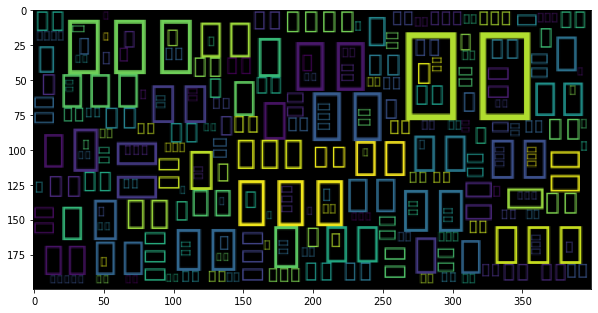

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud)
plt.show()

## EDA

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


123
1
33.40260933480338
26.0


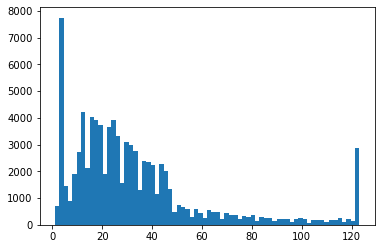

In [ ]:
reviews = df['review']
reviews_len = reviews.apply(len)
print(reviews_len.max())
print(reviews_len.min())
print(reviews_len.mean())
print(reviews_len.median())

plt.hist(reviews_len, bins=70)
plt.show()